## 模型部署&推理
- 模型部署
- 模型推理
- 模型量化

我们会将PyTorch训练好的模型转换为ONNX 格式，然后使用ONNX Runtime运行它进行推理

### 1、ONNX
ONNX( Open Neural Network Exchange) 是 Facebook (现Meta) 和微软在2017年共同发布的，用于标准描述计算图的一种格式。ONNX通过定义一组与环境和平台无关的标准格式，使AI模型可以在不同框架和环境下交互使用，ONNX可以看作深度学习框架和部署端的桥梁，就像编译器的中间语言一样

由于各框架兼容性不一，我们通常只用 ONNX 表示更容易部署的静态图。硬件和软件厂商只需要基于ONNX标准优化模型性能，让所有兼容ONNX标准的框架受益

ONNX主要关注在模型预测方面，使用不同框架训练的模型，转化为ONNX格式后，可以很容易的部署在兼容ONNX的运行环境中

微软，亚马逊 ，Facebook(现Meta) 和 IBM 等公司和众多开源贡献的共同维护下，ONNX 已经对接了下图的多种深度学习框架和多种推理引擎

- ONNX官网：https://onnx.ai/
- ONNX GitHub：https://github.com/onnx/onnx

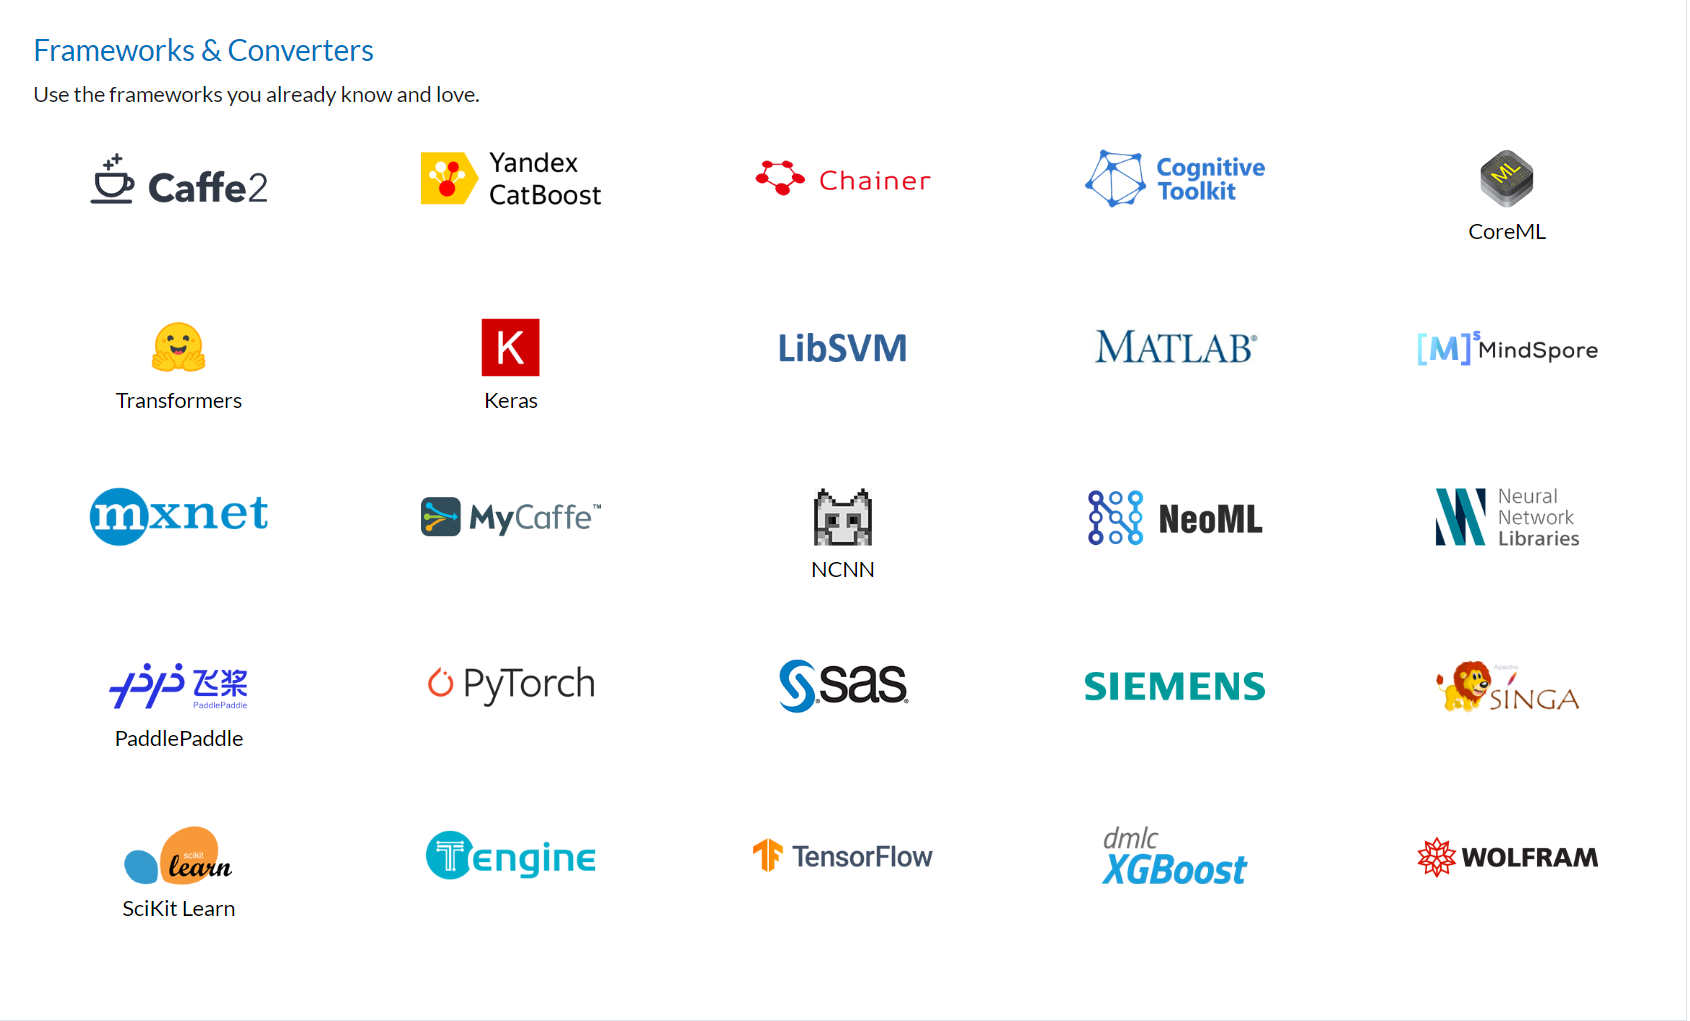



### 2、ONNX Runtime

- ONNX Runtime官网：https://www.onnxruntime.ai/
- ONNX Runtime GitHub：https://github.com/microsoft/onnxruntime

ONNX Runtime 是由微软维护的一个跨平台机器学习推理加速器，它直接对接ONNX，可以直接读取.onnx文件并实现推理，不需要再把 .onnx 格式的文件转换成其他格式的文件

PyTorch借助ONNX Runtime也完成了部署的最后一公里，构建了 PyTorch --> ONNX --> ONNX Runtime 部署流水线


# 安装onnx
pip install onnx 
# 安装onnx runtime
pip install onnxruntime # 使用CPU进行推理
# pip install onnxruntime-gpu # 使用GPU进行推理

注意：ONNX和ONNX Runtime之间的适配关系。我们可以访问ONNX Runtime的Github进行查看
网址：https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md

ONNX Runtime和CUDA之间的适配关系
网址：https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html

### 模型转换为ONNX格式

- 用torch.onnx.export()把模型转换成 ONNX 格式的函数
- 模型导成onnx格式前，我们必须调用model.eval()或者model.train(False)以确保我们的模型处在推理模式下


In [ ]:
import torch.onnx 
# 转换的onnx格式的名称，文件后缀需为.onnx
onnx_file_name = "xxxxxx.onnx"
# 我们需要转换的模型，将torch_model设置为自己的模型
model = torch_model
# 加载权重，将model.pth转换为自己的模型权重
# 如果模型的权重是使用多卡训练出来，我们需要去除权重中多的module. 具体操作可以见5.4节
model = model.load_state_dict(torch.load("model.pth"))
# 导出模型前，必须调用model.eval()或者model.train(False)
model.eval()
# dummy_input就是一个输入的实例，仅提供输入shape、type等信息 
batch_size = 1 # 随机的取值，当设置dynamic_axes后影响不大
dummy_input = torch.randn(batch_size, 1, 224, 224, requires_grad=True) 
# 这组输入对应的模型输出
output = model(dummy_input)
# 导出模型
torch.onnx.export(model,        # 模型的名称
                  dummy_input,   # 一组实例化输入
                  onnx_file_name,   # 文件保存路径/名称
                  export_params=True,        #  如果指定为True或默认, 参数也会被导出. 如果你要导出一个没训练过的就设为 False.
                  opset_version=10,          # ONNX 算子集的版本，当前已更新到15
                  do_constant_folding=True,  # 是否执行常量折叠优化
                  input_names = ['input'],   # 输入模型的张量的名称
                  output_names = ['output'], # 输出模型的张量的名称
                  # dynamic_axes将batch_size的维度指定为动态，
                  # 后续进行推理的数据可以与导出的dummy_input的batch_size不同
                  dynamic_axes={'input' : {0 : 'batch_size'},    
                                'output' : {0 : 'batch_size'}})

### ONNX模型的检验

我们需要检测下我们的模型文件是否可用，我们将通过onnx.checker.check_model()进行检验



In [ ]:
import onnx
# 我们可以使用异常处理的方法进行检验
try:
    # 当我们的模型不可用时，将会报出异常
    onnx.checker.check_model(self.onnx_model)
except onnx.checker.ValidationError as e:
    print("The model is invalid: %s"%e)
else:
    # 模型可用时，将不会报出异常，并会输出“The model is valid!”
    print("The model is valid!")

### ONNX模型可视化
使用netron做可视化。




模型的输入&输出信息：


## 使用ONNX Runtime进行推理


In [ ]:
import onnxruntime
# 需要进行推理的onnx模型文件名称
onnx_file_name = "xxxxxx.onnx"

# onnxruntime.InferenceSession用于获取一个 ONNX Runtime 推理器
ort_session = onnxruntime.InferenceSession(onnx_file_name)  

# 构建字典的输入数据，字典的key需要与我们构建onnx模型时的input_names相同
# 输入的input_img 也需要改变为ndarray格式
ort_inputs = {'input': input_img} 
# 我们更建议使用下面这种方法,因为避免了手动输入key
# ort_inputs = {ort_session.get_inputs()[0].name:input_img}

# run是进行模型的推理，第一个参数为输出张量名的列表，一般情况可以设置为None
# 第二个参数为构建的输入值的字典
# 由于返回的结果被列表嵌套，因此我们需要进行[0]的索引
ort_output = ort_session.run(None,ort_inputs)[0]
# output = {ort_session.get_outputs()[0].name}
# ort_output = ort_session.run([output], ort_inputs)[0]

注意：
- PyTorch模型的输入为tensor，而ONNX的输入为array，因此我们需要对张量进行变换或者直接将数据读取为array格式
- 输入的array的shape应该和我们导出模型的dummy_input的shape相同，如果图片大小不一样，我们应该先进行resize操作
- run的结果是一个列表，我们需要进行索引操作才能获得array格式的结果
- 在构建输入的字典时，我们需要注意字典的key应与导出ONNX格式设置的input_name相同

## 完整代码

### 1. 定义超分辨模型

In [ ]:
import io
import numpy as np
from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
import torch.nn as nn
import torch.nn.init as init

# 定义超分辨网络
class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x
    
	# 模型初始化
    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# 实例化模型
torch_model = SuperResolutionNet(upscale_factor=3)

### 2. 模型导出为ONNX格式

In [ ]:
batch_size = 1    # just a random number
# 加载预训练得到权重
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# 将模型设置为推理模式
torch_model.eval()
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

# 导出模型
torch.onnx.export(torch_model,               # model being run
                  x,             # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,   # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  # variable length axes
                  dynamic_axes={'input' : {0 : 'batch_size'},    
                                'output' : {0 : 'batch_size'}})

### 3、检验ONNX模型

In [ ]:
import onnx
# 我们可以使用异常处理的方法进行检验
try:
    # 当我们的模型不可用时，将会报出异常
    onnx.checker.check_model("super_resolution.onnx")
except onnx.checker.ValidationError as e:
    print("The model is invalid: %s"%e)
else:
    # 模型可用时，将不会报出异常，并会输出“The model is valid!”
    print("The model is valid!")

### 4. 使用ONNX Runtime进行推理

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

# 将张量转化为ndarray格式
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# 构建输入的字典和计算输出结果
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# 比较使用PyTorch和ONNX Runtime得出的精度
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

### 5. 进行实际预测并可视化

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# 读取图片
img = Image.open("/cat_224x224.jpg")
# 对图片进行resize操作
resize = transforms.Resize([224, 224])
img = resize(img)

img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0)
# 构建输入的字典并将value转换位array格式
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

# 保存最后得到的图片
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")

final_img.save("/cat_superres_with_ort.jpg")